# Our Problem
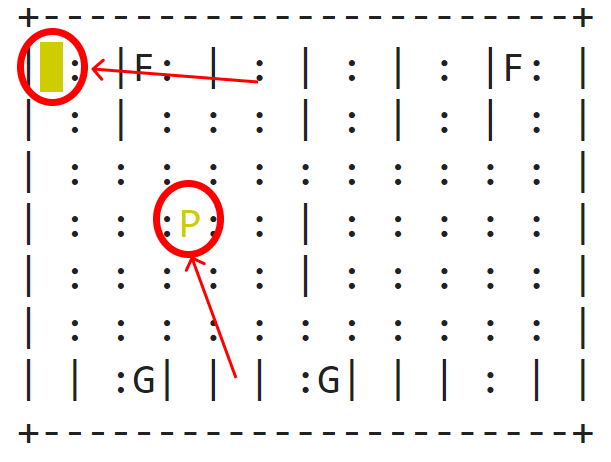

# Our Tools

## Monte Carlo Simulation

In [1]:
!pip install -q 'git+https://github.com/sarah-keren/multi-taxi'

ERROR: Invalid requirement: "'git+https://github.com/sarah-keren/multi-taxi'"


In [1]:
import numpy as np
from multi_taxi.world.maps import DEFAULT_MAP, BIG_MAP
from IPython.display import clear_output
import matplotlib.pyplot as plt
from multi_taxi import multi_taxi_v0
from multi_taxi import Event

In [2]:
customized_reward = {
    Event.PICKUP: 100,
    Event.BAD_PICKUP: -1,
    Event.HIT_OBSTACLE: -1,
    Event.STEP: -1
}
# This variable will be used later in Monte Carlo Tree Search 
N_SIMULATIONS = 100
def new_environment_creator(taxi_pos, passenger_pos, 
                            num_taxis=1,num_passengers=1, 
                            pickup_only=True, can_see_other_taxi_info=False, 
                            domain_map=DEFAULT_MAP,reward_table=customized_reward):
    """
    A helper function to setup a new environment with predefined taxi and passenger locations
    """
    new_env = multi_taxi_v0.env(num_taxis=num_taxis, num_passengers=num_passengers, pickup_only=pickup_only, domain_map=domain_map,
                                can_see_other_taxi_info=can_see_other_taxi_info,reward_table=reward_table, 
                                render_mode='human', allow_arrived_passengers_on_reset=False)
    new_env.reset()

    state = new_env.state()
    state.taxis[0].location = taxi_pos
    state.passengers[0].location = passenger_pos
    new_env.unwrapped.set_state(state)

    return new_env

In [16]:
taxi_position = (0,0)
passenger_position = (3,3)
env = new_environment_creator(taxi_position, passenger_position)

done = False
step = 0
while not done:
    action = np.random.randint(5)
    env.step(action)
    obs, reward, done, trunc, info = env.last()
    clear_output(wait=True)
    print(step)
    env.render()
    step += 1

209
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 210, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



![monte_carlo_control_schema](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Monte_Carlo_Control_complete.png)

# Monte Carlo Control Algorithm
![monte_carlo_control_algorithm](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/monte_carlo_control_algorithm.png)

In [20]:
from collections import defaultdict
import numpy as np
import json
from copy import deepcopy
import time

class MonteCarloControl:
    def __init__(self, state, gamma:float = 0.9, max_episode_number:int=10_000,
                 max_episode_length:int = 1_000) -> None:
        self.state = state
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.N = defaultdict(lambda: defaultdict(lambda: 0))
        self.visited = set()
        self.episode_number = 0
        self.gamma = gamma
        self.max_episode_number = max_episode_number
        self.max_episode_length = max_episode_length
    
    def save(self, filename):
        state = self.state.unwrapped.state()
        taxi_position = state.taxis[0].location
        passenger_position = state.passengers[0].location
        json_data = {
            'Q': self.Q,
            'N': self.N,
            'episode_number': self.episode_number,
            'gamma': self.gamma,
            'max_episode_number': self.max_episode_number,
            'max_episode_length': self.max_episode_length,
            'taxi_position': taxi_position,
            'passenger_position': passenger_position
        }
        with open(filename, 'w') as f:
            json.dump(json_data, f)


    def load(self, filename):
        with open(filename, 'r') as f:
            json_data = json.load(f)
        self.Q = json_data['Q']
        self.N = json_data['N']
        self.episode_number = json_data['episode_number']
        self.gamma = json_data['gamma']
        self.max_episode_number = json_data['max_episode_number']
        self.max_episode_length = json_data['max_episode_length']
        taxi_position = json_data['taxi_position']
        passenger_position = json_data['passenger_position']
        state = self.env.unwrapped.state()
        state.taxis[0].location = taxi_position
        state.passengers[0].location = passenger_position
        self.state.unwrapped.set_state(state)

    def policy(self, state, epsilon = None, warn=False):
        if epsilon is None:
            epsilon = 1/np.sqrt(self.episode_number + 1)
        else:
            epsilon = epsilon
        number_of_actions = len(self.state.unwrapped.get_action_map('taxi_0').values())
        if np.random.random() < epsilon:
            action = np.random.choice(number_of_actions)
        else:
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            if state in self.visited:
                action = max(self.Q[state], key=self.Q[state].get)
            else:
                if warn:
                    print('The action was not in Q! Chose randomly')
                action = np.random.choice(number_of_actions)
        return action
    
    def train(self):
        for _ in range(self.max_episode_number):
            self.episode_number += 1
            current_episode_state = deepcopy(self.state)
            episode = []
            for _ in range(self.max_episode_length):

                action = self.policy(current_episode_state)
                old_state = current_episode_state
                current_episode_state.step(action)
                obs, reward, done, trunc, info = current_episode_state.last()
                episode.append((old_state, action, reward))
                if done:
                    break
            self.update(episode)
    
    def update(self, episode):
        G = 0
        for i, (state, action, reward) in enumerate(reversed(episode)):
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            G = (self.gamma**i) * G + reward
            self.visited.add(state)
            self.N[state][action] = self.N[state][action] + 1
            self.Q[state][action] = self.Q[state][action]+(G - self.Q[state][action]) / self.N[state][action]
    
    def run(self, starting_state=None, max_number_of_steps=100):
        if starting_state is not None:
            current_state = deepcopy(starting_state)
        else:
            current_state = deepcopy(self.state)
        for i in range(1,max_number_of_steps+1):
            action = self.policy(current_state, epsilon=0)
            current_state.step(action)
            obs, reward, done, trunc, info = current_state.last()
            clear_output(wait=True)
            print(i)
            current_state.unwrapped.render()
            if done:
                break
    
    def step_and_update(self, starting_state=None, max_number_of_steps=150, max_number_of_simulated_episodes=100):
        if starting_state is not None:
            current_state = deepcopy(starting_state)
        else:
            current_state = deepcopy(self.state)
        steps = 0
        for i in range(1,max_number_of_steps+1):
            steps = i
            # TRAINING STEP
            self.episode_number = 0
            for _ in range(max_number_of_simulated_episodes):
                # train on the current state
                self.episode_number += 1
                current_training_state = deepcopy(current_state)
                episode = []
                for _ in range(self.max_episode_length):

                    action = self.policy(current_training_state)
                    old_state = deepcopy(current_training_state)
                    current_training_state.step(action)
                    obs, reward, done, trunc, info = current_training_state.last()
                    episode.append((old_state, action, reward))
                    if done:
                        break
                self.update(episode)
            # ACTUAL STEP
            action = self.policy(current_state, warn=True)
            old_state = current_state.unwrapped.state().taxis[0].location
            current_state.step(action)
            obs, reward, done, trunc, info = current_state.last()
            time.sleep(1)
            clear_output(wait=True)
            print(i)
#             print(f"action executed:{action}")
#             print(f"q values: {self.Q[old_state].items()}")
            current_state.unwrapped.render()
            if done:
                break
        return steps

In [21]:
env = new_environment_creator((0,0), (3,3))
monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_episode_number=100, max_episode_length=1_000)
#monte_carlo_control.train()

In [22]:
monte_carlo_control.step_and_update(max_number_of_simulated_episodes=10)

13
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 13, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



13

# Monte Carlo Tree Search

# The 4 steps of MCTS

MCTS consists of four main steps: selection, expansion, simulation, and backpropagation.

1. **Selection.** Select a leaf node using **tree policy**.
2. **Expansion.** **Add children** to the selected leaf using unexplored actions
3. **Rollout.** From the selected child **simulate** an **episode** using the **rollout policy**
4. **Backpropagation**. **Update** the average **value** of the nodes starting **from** the selected **child** up **to** the **root** using the results of the rollout episode
    - ATTENTION: No values are saved for the states and actions visited by the rollout policy beyond the tree! 

![mcts_4_steps](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/mcts_4_steps.png)

MCTS **repeats** this cycle until **no time** is left (starting at the root node each time). **Finally**, MCTS **chooses** the **action** to make from the root node.

# Rollout policy and Tree policy

* **Rollout policy**: a simple policy generating actions in the **simulated trajectories**

* **Tree policy**: policy for traversing the tree and **selecting** a **child node** that is most promising according to a selection policy, which balances exploration and exploitation of the search space. 
    * examples : $\epsilon$-greedy, UCB 
    
    * $UCB = \underbrace{Q}_{exploitation} + \underbrace{C \sqrt{\frac{\log(N)}{n}}}_{exploration}$
   
   Where: 
   - $Q$ is the average Q-value of the considered state-action pair
   - $C$ is a constant that balances exploration and exploitation
   - $N$ is the total number of times that the current node has been visited
   - $n$ is the number of times that the considered child node has been visited


In [13]:
customized_reward = {
    Event.PICKUP: 100,
    Event.BAD_PICKUP: -1,
    Event.HIT_OBSTACLE: -1,
    Event.STEP: -1
}
N_SIMULATIONS = 100

In [14]:
def new_environment_creator(taxi_pos, passenger_pos, 
                            num_taxis=1,num_passengers=1, 
                            pickup_only=True, can_see_other_taxi_info=False, 
                            domain_map=DEFAULT_MAP,reward_table=customized_reward):
    """
    A helper function to setup a new environment with predefined taxi and passenger locations
    """
    new_env = multi_taxi_v0.env(num_taxis=num_taxis, num_passengers=num_passengers, pickup_only=pickup_only, domain_map=domain_map,
                                can_see_other_taxi_info=can_see_other_taxi_info,reward_table=reward_table, 
                                render_mode='human', allow_arrived_passengers_on_reset=False)
    new_env.reset()

    state = new_env.state()
    state.taxis[0].location = taxi_pos
    state.passengers[0].location = passenger_pos
    new_env.unwrapped.set_state(state)

    return new_env

In [15]:
class MonteCarloTreeSearchNode():
    def __init__(self, state, n_simulations=N_SIMULATIONS, parent=None, parent_action=None, new_env_creator=new_environment_creator, gamma = 0.9):
        self.state = state  #represents the state
        self.parent = parent #None for the root node, otherwise it is equal to the node it is derived from.
        self.parent_action = parent_action #None for the root node, otherwise it is equal to the action which it’s parent carried out.
        self.children = [] #Contains all possible actions from the current node.
        self.number_of_visits = 0 #Number of times current node is visited.
        self.average_reward = 0
        self._untried_actions = set(self.get_legal_actions()) #Represents the list of all possible actions. An action is a move which has to be carried out.
        self.terminal_state = False
        self.new_env_creator = new_env_creator
        self.gamma = gamma
        self.n_simulations = n_simulations
    
    def expand(self):
        """
        From the present state, next state is generated depending on the action 
        which is carried out. In this step all the possible child nodes 
        corresponding to generated states are appended to the children array 
        and the child_node is returned. The states which are possible from the
        present state are all generated and the child_node corresponding to this
        generated state is returned.
        """
        # selection
        action = self._untried_actions.pop()
        
        state = self.state.unwrapped.state()
        taxi_pos = state.taxis[0].location
        passenger_pos = state.passengers[0].location
        new_env = self.new_env_creator(taxi_pos,passenger_pos)
        new_env.step(action)
        obs, reward, done, trunc, info = new_env.last()
        child_node = MonteCarloTreeSearchNode(new_env, new_env_creator= self.new_env_creator, parent=self, parent_action=action, gamma=self.gamma)
        child_node.terminal_state = done
        
        self.children.append(child_node)
        return child_node
    
    def is_terminal_node(self):
        """
        This is used to check if the current node is terminal or not. 
        Terminal node is reached when the game is over.
        """
        return self.terminal_state
    
    def rollout(self):
        """
        From the current state, entire game is simulated till there is an 
        outcome for the game. This outcome of the game is returned.
        """
        
        state = self.state.env.unwrapped.state()
        taxi_pos = state.taxis[0].location
        passenger_pos = state.passengers[0].location
        
        current_rollout_state = self.new_env_creator(taxi_pos,passenger_pos)

        _reward = 0
        step = 0
        done = False
        while not done:
            possible_moves = self.get_legal_actions()

            action = self.rollout_policy(possible_moves)
            current_rollout_state.step(action)
            obs, reward, done, trunc, info = current_rollout_state.last()
            _reward += reward *(self.gamma ** step)
            step += 1
        return _reward
    
    def backpropagate(self, reward):
        """
        In this step all the statistics for the nodes are updated. 
        Untill the parent node is reached, the number of visits for 
        each node is incremented by 1.
        """
        self.number_of_visits += 1.
        self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)
        if self.parent:
            self.parent.backpropagate(reward)
            
    def is_fully_expanded(self):
        """
        All the actions are poped out of _untried_actions one by one. 
        When it becomes empty, that is when the size is zero, it is fully expanded.
        """
        return len(self._untried_actions) == 0
    
    def ucb1(self, child, c_param=2):
        if self.number_of_visits == 0 or child.number_of_visits == 0:
            return float("inf")
        return child.average_reward + \
                c_param*np.sqrt(2*np.log(self.number_of_visits)/child.number_of_visits)
    
    
    def best_child(self, c_param=0.8):
        """
        Once fully expanded, this function selects the best child out of 
        the children array. The first term in the formula corresponds to 
        exploitation and the second term corresponds to exploration.
        """
        choices_weights = [self.ucb1(child, c_param) for child in self.children] 
        return self.children[np.argmax(choices_weights)]
    
    def rollout_policy(self, possible_moves):
        """
        Randomly selects a move out of possible moves. 
        This is an example of random playout.
        """
        return possible_moves[np.random.randint(len(possible_moves))]
    
    def _tree_policy(self):
        """
        Selects node to run rollout.
        """
        current_node = self
        while not current_node.is_terminal_node():

            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node
    
    def best_action(self):
        """
        This is the best action function which returns the 
        node corresponding to best possible move. The step of expansion, 
        simulation and backpropagation are carried out by the code above.
        """
        
        for i in range(self.n_simulations):
            v = self._tree_policy()
            reward = v.rollout()
            v.backpropagate(reward)

        return self.best_child(c_param=0.)
    
    def get_legal_actions(self): 
        '''
        Modify according to your game or
        needs. Constructs a list of all
        possible actions from current state.
        Returns a list.
        '''
        return list(self.state.unwrapped.get_action_map('taxi_0').values())   

In [16]:
#N_SIMULATIONS = 20
env = new_environment_creator((0,0), (3,3))
root = MonteCarloTreeSearchNode(new_env_creator = new_environment_creator, state = env, n_simulations = 20, gamma=0.78)
root.state.unwrapped.render()
selected_node = root.best_action()
step = 1
while not selected_node.terminal_state:
    selected_node = selected_node.best_action()
    clear_output(wait=True)
    print(step)
    selected_node.state.env.render()
    step += 1

23
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



# Rapid Action Value (RAVE)
- It created the first program to achieve dan (master) level in Go. [[Gelly, Silver 2011]](https://www.sciencedirect.com/science/article/pii/S000437021100052X)
- **MCTS** requires a **lot of simulations** to sample several pairs of state and action
- To **speed up** this estimate we can introduce a **bias**
- We will **update** the pair $\langle s, a \rangle$ **with** the **reward** obtained **using** $a$ **from** any state in the **subtree** of $s$ (AMAF heuristic)
![rave](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/rave.png)

- In order to balance these two estimates we will use the following formula
$$
\tilde{Q}(s,a) = (1-\beta(s,a))*Q(s,a) + \beta(s,a)*RAVE(s,a)
$$
Where:
- $\tilde{Q}(s,a)$ is the final value attributed to the pair $\langle s, a \rangle$
- $\beta(s,a)$ is a parameter which dynamically balances these two estimates
- $Q(s,a)$ is the average Q-value of $\langle s, a \rangle$
- $RAVE(s,a)$ is the RAVE value of $\langle s, a \rangle$

$$\beta(s,a) = \sqrt{\frac{k}{3N(s,a)+k}}$$
Where:
- $N(s)$ is the number of times that we visited the current node
- $k$ is an hyperparameter that sets the number of simulation at which $Q$ and $RAVE$ are given the same weight

![beta](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/beta.png)

In [18]:
class RAVEMonteCarloTreeSearchNode(MonteCarloTreeSearchNode):
  '''Introduce RAVE optimization to MCTS'''
  def __init__(self, state, n_simulations=N_SIMULATIONS, parent=None, parent_action=None, new_env_creator=new_environment_creator, k=3, gamma=0.78):
    super().__init__(state, n_simulations, parent,parent_action,new_env_creator, gamma=gamma)
    self.average_reward_rave = 0
    self.number_of_visits_rave = 0
    self.k = k

  def rave(self, reward):
    self.number_of_visits_rave += 1.
    self.average_reward_rave = self.average_reward_rave + (1/self.number_of_visits_rave)*(reward-self.average_reward_rave)

  def ucb1(self, child, c_param=0.8):
     ucb =  float('inf') if (child.number_of_visits == 0 or self.number_of_visits == 0) else child.average_reward + \
     c_param*np.sqrt( \
          2*np.log(self.number_of_visits)/ child.number_of_visits \
     )
     beta = np.sqrt(self.k / (3 * self.number_of_visits + self.k))
     first_term = float('inf') if ucb == float('inf') \
                  else (1-beta)*ucb
     second_term = float('inf') if child.number_of_visits_rave == 0 \
                  else beta*child.average_reward_rave
     return first_term + second_term
  
  def best_child(self, c_param=0.8):
    choices_weights = [self.ucb1(child, c_param) for child in self.children] 
    return self.children[np.argmax(choices_weights)]
  
  def best_action(self):
    for _ in range(self.n_simulations):
      v = self._tree_policy()
      reward, taken_actions = v.rollout()
      v.backpropagate(reward, taken_actions)
    return self.best_child(c_param=0.)
  
  def rollout(self):
    state = self.state.env.unwrapped.state()
    taxi_pos = state.taxis[0].location
    passenger_pos = state.passengers[0].location
    
    current_rollout_state = self.new_env_creator(taxi_pos,passenger_pos)

    _reward = 0
    step = 0
    done = False
    taken_actions = []
    while not done:
        possible_moves = self.get_legal_actions()

        action = self.rollout_policy(possible_moves)
        current_rollout_state.step(action)
        obs, reward, done, trunc, info = current_rollout_state.last()
        _reward += reward*(self.gamma**step)
        taken_actions.append(action)
        step += 1
    return _reward, taken_actions
  
  def backpropagate(self, reward, taken_actions):
    self.number_of_visits += 1
    self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)
    
    for action in set(taken_actions):
      for child in self.children:
        if child.parent_action == action:
          child.rave(reward)
    if self.parent is not None:
      self.parent.backpropagate(reward, taken_actions)
  
  def is_fully_expanded(self):
     return len(self.children) > 0

  def create_all_children(self):
    if self.is_fully_expanded():
      raise Exception('Node is already fully expanded')
    
    for action in self._untried_actions:
      
      state = self.state.unwrapped.state()
      taxi_pos = state.taxis[0].location
      passenger_pos = state.passengers[0].location
      new_env = self.new_env_creator(taxi_pos,passenger_pos)
      new_env.step(action)
      obs, reward, done, trunc, info = new_env.last()
      child_node = RAVEMonteCarloTreeSearchNode(new_env, parent=self, parent_action=action, gamma=self.gamma, k=self.k, new_env_creator=self.new_env_creator)
      child_node.terminal_state = done
      
      self.children.append(child_node)

  def _tree_policy(self):
      """
      Selects node to run rollout.
      """
      current_node = self
      while not current_node.is_terminal_node():

          if not current_node.is_fully_expanded():
              current_node.create_all_children()
              return current_node.best_child()
          
          current_node = current_node.best_child()
      return current_node

In [19]:
#N_SIMULATIONS = 20
env = new_environment_creator(taxi_pos=(0,0),passenger_pos=(3,3))
root = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = 20, k=10, gamma=0.78)
root.state.unwrapped.render()
selected_node = root.best_action()
step = 1
while not selected_node.terminal_state:
    selected_node = selected_node.best_action()
    clear_output(wait=True)
    print(step)
    selected_node.state.env.render()
    step += 1

9
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



In [127]:
def create_evaluate_policy(algo ,simulations):
    N_SIMULATIONS = simulations
    if (algo=="mcts"):   
        env = new_environment_creator(taxi_pos=(0,0),passenger_pos=(3,3))
        root = MonteCarloTreeSearchNode(state = env, n_simulations=simulations, gamma=0.78)
        root.state.unwrapped.render()
        selected_node = root.best_action()
        step = 1
        while not selected_node.terminal_state:
            selected_node = selected_node.best_action()
            clear_output(wait=True)
            print(step)
            selected_node.state.env.render()
            step += 1
        return step
    elif (algo=="RAVE"):
        env = new_environment_creator(taxi_pos=(0,0),passenger_pos=(3,3))
        root = RAVEMonteCarloTreeSearchNode(state = env, k=10, gamma=0.78)
        root.state.unwrapped.render()
        selected_node = root.best_action()
        step = 1
        while not selected_node.terminal_state:
            selected_node = selected_node.best_action()
            clear_output(wait=True)
            print(step)
            selected_node.state.env.render()
            step += 1
        return step
    elif algo == 'mcc':
        env = new_environment_creator((0,0), (3,3))
        monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_episode_length=1_000)
        step = monte_carlo_control.step_and_update(max_number_of_simulated_episodes=simulations, max_number_of_steps=150)
        return step
    else:
        raise ValueError('Choose an algorithm among mcts, RAVE and mcc!')


In [128]:
import matplotlib.pyplot as plt
import random
def plot_steps_per_simulations(algo, simulations_per_step, repeat_evaluation):

    data_to_plot = [[] for _ in range(len(algo))]

    
    for sim in simulations_per_step:
        # sample random actions for all buildings
        for i,alg in enumerate(algo): 
            print(f"{alg} for {sim} simulations")
            steps=0
            for _ in range(repeat_evaluation):
                steps+=create_evaluate_policy(alg ,sim)
            data_to_plot[i].append(steps/repeat_evaluation)

    #steps=simulations_per_step[sim]
    # collect the data

    print(data_to_plot)
    # plotting the data collected
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.set_title(f"steps taken for algorithm {algo}")
    for i, _ in enumerate(algo): 
        ax.plot(simulations_per_step, data_to_plot[i], '-o', label=algo[i])
    ax.set_xlabel("simulations per step")
    ax.set_ylabel("Steps")
    ax.grid()
    ax.legend()
    plt.show()

7
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True

[[33.3, 10.0, 10.1, 9.2, 8.9], [14.0, 17.5, 12.1, 14.8, 13.0], [19.0, 18.0, 15.5, 12.9, 16.7]]


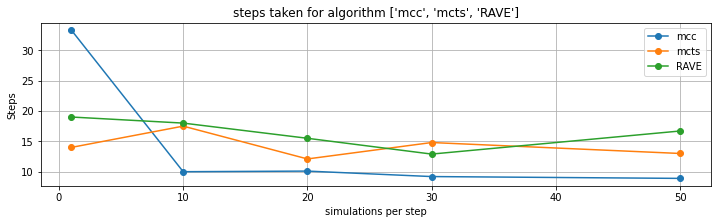

In [129]:
#plot_steps_per_simulations(["mcc", "mcts", "RAVE"],[10,20,30,50],10)

![benchmark](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/benchmark.png)

# TODO 1
1. Define a new function which calls new_environment_creator with passenger_location = (6,7) with the DEFAULT_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE

# TODO 2
1. Define a new function which calls new_environment_creator with taxi position = (2,0) and with domain_map=BIG_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE

# TODO 3 (Optional)
1. Define a new function which calls new_environment_creator with taxi position = (2,0) with passenger_location = (6,7) and with domain_map=BIG_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE